In [450]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

In [451]:
files = ["asian", "black", "indian", "latino_hispanic", "maori", "middle_eastern", "white", "pasifika"]

attributes = ["Gender", "Ethnicity", "Mood", "Age"]

def get_range(age_range):
    if age_range == "more than 70":
        return range(70, 120)
    bounds = str(age_range).split("-")

    if len(bounds) == 1:
        lower = (int(int(bounds[0]) / 10)) * 10
        return range(lower, lower + 10)

    return range(int(bounds[0]), int(bounds[1]) + 1)

def get_str_range(age):
    if int(age) >= 70:
        return "more than 70"
    r = get_range(age)
    return f"{r[0]}-{r[9]}"

def get_accuracies(df):
    c_results = {}
    for attr in attributes:
        gb = df.groupby(f"{attr} accurate")[f"{attr} accurate"].count()
        c_results[attr] = [(gb.index[i], gb[i]) for i in range(len(gb.index))]

    return c_results

In [452]:
dfs = {}

per_category_results = {}
for f in files:
    path = f"{f}_stats.csv"
    df = pd.read_csv(path, index_col = "Unnamed: 0")
    df["True Ethnicity"] = df["True Ethnicity"].str.replace("_", " ").str.lower()
    df["Classified Mood"] = df["Classified Mood"].str.replace("surprise", "surprised")
    df["Classified Mood"] = df["Classified Mood"].str.replace("disgust", "disgusted")
    if f == "pasifika" or f == "maori":
        df = df.sample(n = 100)
        df["True Gender"] = df["True Gender"].str.replace("Female", "Woman")
        df["True Gender"] = df["True Gender"].str.replace("Male", "Man")
        df["True Ethnicity"] = df["True Ethnicity"].str.replace("european", "maori")
        df["True Age"] = df["True Age"].apply(get_str_range)
        
    df.insert(3, "Gender accurate", df["True Gender"] == df["Classified Gender"])
    df.insert(7, "Ethnicity accurate", df["True Ethnicity"] == df["Classified Ethnicity"])
    df.insert(11, "Mood accurate", df["True Mood"] == df["Classified Mood"])
    df.insert(15, "Age accurate", df.apply(lambda row: row["Classified Age"] in get_range(row["True Age"]), axis = 1))
    accuracy = get_accuracies(df)
    
    per_category_results[f] = accuracy

    dfs[f] = df

In [453]:
# All categories
all_df = pd.concat(dfs.values())

all_acc = get_accuracies(all_df)
all_df

,True Gender,Classified Gender,Gender confidence,Gender accurate,True Ethnicity,Classified Ethnicity,Ethnicity confidence,Ethnicity accurate,True Mood,Classified Mood,Mood confidence,Mood accurate,True Age,Classified Age,Age confidence,Age accurate
0,Woman,Woman,1.0,True,asian,asian,1.0,True,neutral,happy,1.0,False,20-29,29,1.0,True
1,Woman,Man,1.0,False,asian,indian,1.0,False,neutral,fear,1.0,False,3-9,23,1.0,False
2,Woman,Man,1.0,False,asian,asian,1.0,True,neutral,angry,1.0,False,20-29,22,1.0,True
3,Woman,Woman,1.0,True,asian,asian,1.0,True,neutral,happy,1.0,False,20-29,29,1.0,True
4,Man,Man,1.0,True,asian,asian,1.0,True,neutral,happy,1.0,False,20-29,23,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,Woman,Woman,1.0,True,pacific islander,latino hispanic,1.0,False,happy,sad,1.0,False,40-49,21,1.0,False
84,Man,Man,1.0,True,pacific islander,latino hispanic,1.0,False,happy,happy,1.0,True,50-59,32,1.0,False
66,Man,Man,1.0,True,pacific islander,black,1.0,False,fear,fear,1.0,True,10-19,23,1.0,False
38,Man,Man,1.0,True,pacific islander,black,1.0,False,happy,happy,1.0,True,60-69,54,1.0,False


In [454]:
# Matrix generation

def confusion_matrix(group, attr, options, normalise = True):
    row = {}
    correct_option = list(group[f"True {attr}"])[0]
    for o in options:
        correct = correct_option == o
        coeff = (100 * (1 / len(group)) * (1 if correct else -1)) if normalise else 1
        if attr == "Age":
            correct = correct_option == get_str_range(o)
            coeff *= -correct if correct and normalise else 1
            num_correct = group[["True Age", "Classified Age"]]\
                                            .apply(lambda row: (row["Classified Age"] in get_range(row["True Age"])) & (get_str_range(row["Classified Age"]) == get_str_range(o)), axis = 1)\
                                            .sum()
            
            total_classified = coeff * group[["True Age", "Classified Age"]]\
                                                        .apply(lambda row: int(row["Classified Age"] in get_range(o)), axis = 1)\
                                                        .sum()
            
            row[get_str_range(o)] = (num_correct, total_classified)

        else:
            num_correct = sum((group[f"Classified {attr}"] == group[f"True {attr}"]) & (group[f"Classified {attr}"] == o))
            total_classified = coeff * sum(group[f"Classified {attr}"] == o)
            row[o] = (num_correct, total_classified)


    return pd.Series(row)

# def confusion_matrix(group, attr, options):
#     row = {}
#     correct_option = list(group[f"True {attr}"])[0]
#     for o in options:
#         correct = correct_option == o
#         if attr == "Age":
#             correct = correct_option == get_str_range(o)
#             num_correct = group[["True Age", "Classified Age"]]\
#                                             .apply(lambda row: o == correct_option and int(row["Classified Age"] in get_range(o)), axis = 1)\
#                                             .sum()
            
#             total_classified = group[["True Age", "Classified Age"]]\
#                                                         .apply(lambda row: int(row["Classified Age"] in get_range(o)), axis = 1)\
#                                                         .sum()
            
#             row[get_str_range(o)] = (num_correct, total_classified)

#         else:
#             num_correct = sum((group[f"Classified {attr}"] == o) & (o == correct_option))
#             total_classified = sum(group[f"Classified {attr}"] == o)
#             row[o] = (num_correct, total_classified)


#     return pd.Series(row)

norm_matrices = {}
for attr in attributes:
    options = set(all_df[f"Classified {attr}"])
    matrix = all_df.groupby(f"True {attr}").apply(confusion_matrix, attr = attr, options = options, normalise = True)
    new_order = list(filter(lambda i: i in matrix.columns, matrix.index))
    new_order = new_order + list(filter(lambda c: c not in new_order, matrix.columns))
    matrix = matrix[list(new_order)]
    norm_matrices[attr] = matrix.applymap(lambda cell: cell[1])

c_matrices = {}
for att1 in attributes:
    c_matrices[att1] = {}
    for att2 in attributes:
        options = set(all_df[f"Classified {att2}"])
        matrix = all_df.groupby(f"True {att1}").apply(confusion_matrix, attr = att2, options = options, normalise = False)
        c_matrices[att1][att2] = matrix

In [455]:
# Precision/recall calculations

pr_results = {}
for attr, matrix in matrices.items():
    prs = []
    for c in matrix.columns:
        tp = matrix[c].loc[[c]][0]
        fp = sum(matrix[c].abs()) - tp
        fn = matrix.loc[[c]].abs().sum(axis = 1)[0] - tp
        tn = all_df.groupby(f"True {attr}").size().sum() - all_df.groupby(f"True {attr}").size()[c]
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        specificity = tn / (tn + fp)

        prs.append((c, precision, recall, specificity))
    pr_results[attr] = prs

# Visualisation

## Accuracies

### Total accuracy

[35.875, 58.0, 73.75, 66.25]


(0.0, 100.0)

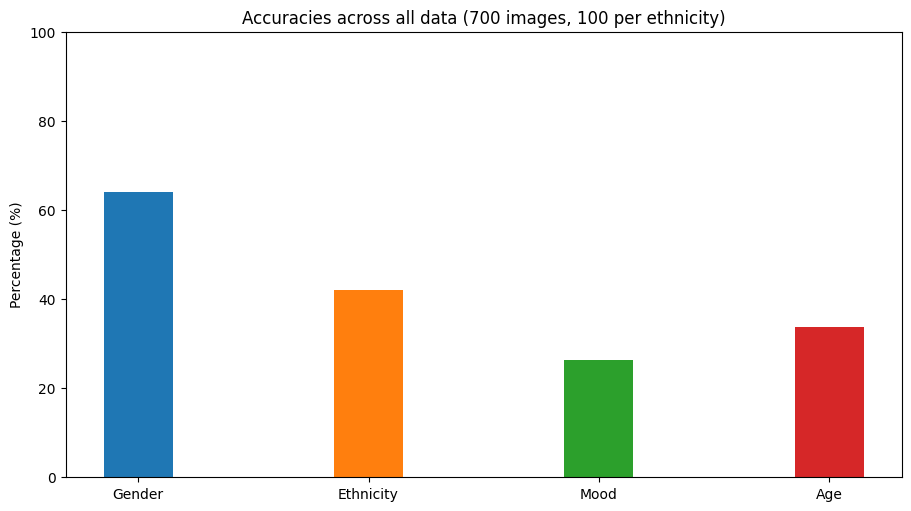

In [456]:
ethnicities = files

fig, ax = plt.subplots(layout = "constrained")
fig.set_size_inches(9, 5)
width = 0.3
x = np.arange(len(attributes))

false_heights = [all_acc[attr][0][1] / len(ethnicities) for attr in attributes]
true_heights = [100 - h for h in false_heights]
print(false_heights)

ax.bar(x, true_heights, width, color = ["tab:blue", "tab:orange", "tab:green", "tab:red"])

ax.set_ylabel('Percentage (%)')
ax.set_title('Accuracies across all data (700 images, 100 per ethnicity)')
ax.set_xticks(x, attributes)
ax.set_ylim(0, 100)

### Accuracy by ethnicity

(0.0, 100.0)

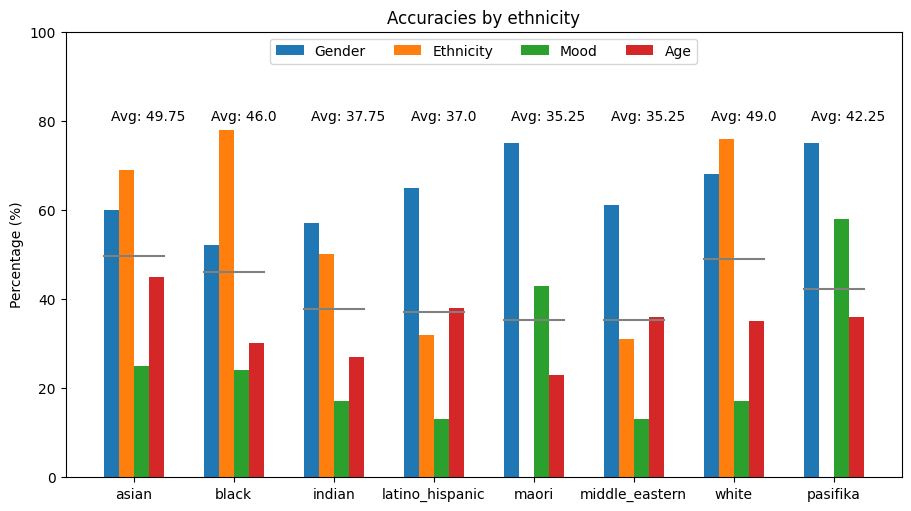

In [457]:
fig, ax = plt.subplots(layout = "constrained")
fig.set_size_inches(9, 5)
multiplier = 0
width = 0.15
x = np.arange(len(ethnicities))


for attr in attributes:
    false_heights = [per_category_results[d][attr][0][1] for d in per_category_results]
    true_heights = [100 - x for x in false_heights]

    offset = width * multiplier
    ax.bar(x + offset, true_heights, width, label = attr)
    
    multiplier += 1

for eth in range(len(ethnicities)):
    avg = sum(100 - per_category_results[ethnicities[eth]][x][0][1] for x in per_category_results[ethnicities[eth]]) / len(attributes)
    ax.text(x[eth], 80, f"Avg: {avg}")
    ax.plot([x[eth] - width / 2, x[eth] + width * 3.5], [avg, avg], color = "gray")

ax.set_ylabel('Percentage (%)')
ax.set_title('Accuracies by ethnicity')
ax.set_xticks(x + 1.5*width, ethnicities)
ax.legend(loc='upper center', ncols = 4)
ax.set_ylim(0, 100)

### Accuracy matrices

Text(0.48, 0.52, 'Classification success per attribute\n Negative % indicates incorrect classifications')

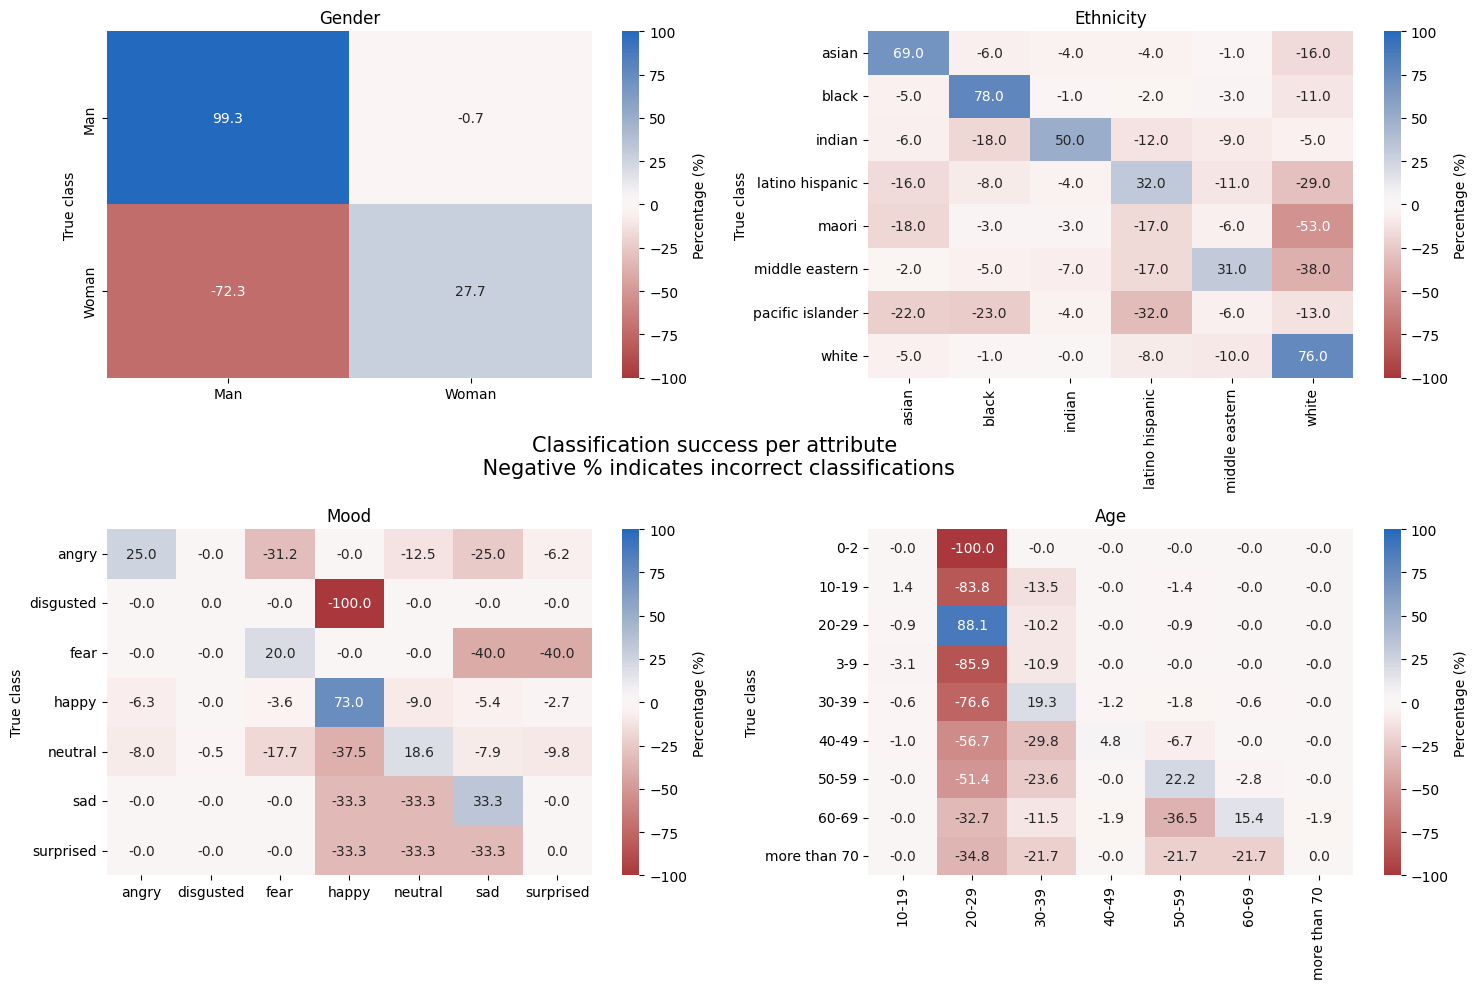

In [458]:
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

for i, (key, data) in enumerate(norm_matrices.items()):
    row, col = divmod(i, 2)
    sn.heatmap(data, fmt = '.1f', annot = True, cmap = "vlag_r", ax = axes[row, col],
               vmin = -100, vmax = 100,
               cbar_kws = {"label": "Percentage (%)"})
    axes[row, col].set_title(key)
    axes[row, col].set_ylabel("True class")

plt.tight_layout()
plt.figtext(0.48, 0.52, "Classification success per attribute\n Negative % indicates incorrect classifications", ha = "center", fontsize = 15)

## Precision, Recall, Sensitivity and Specicifity

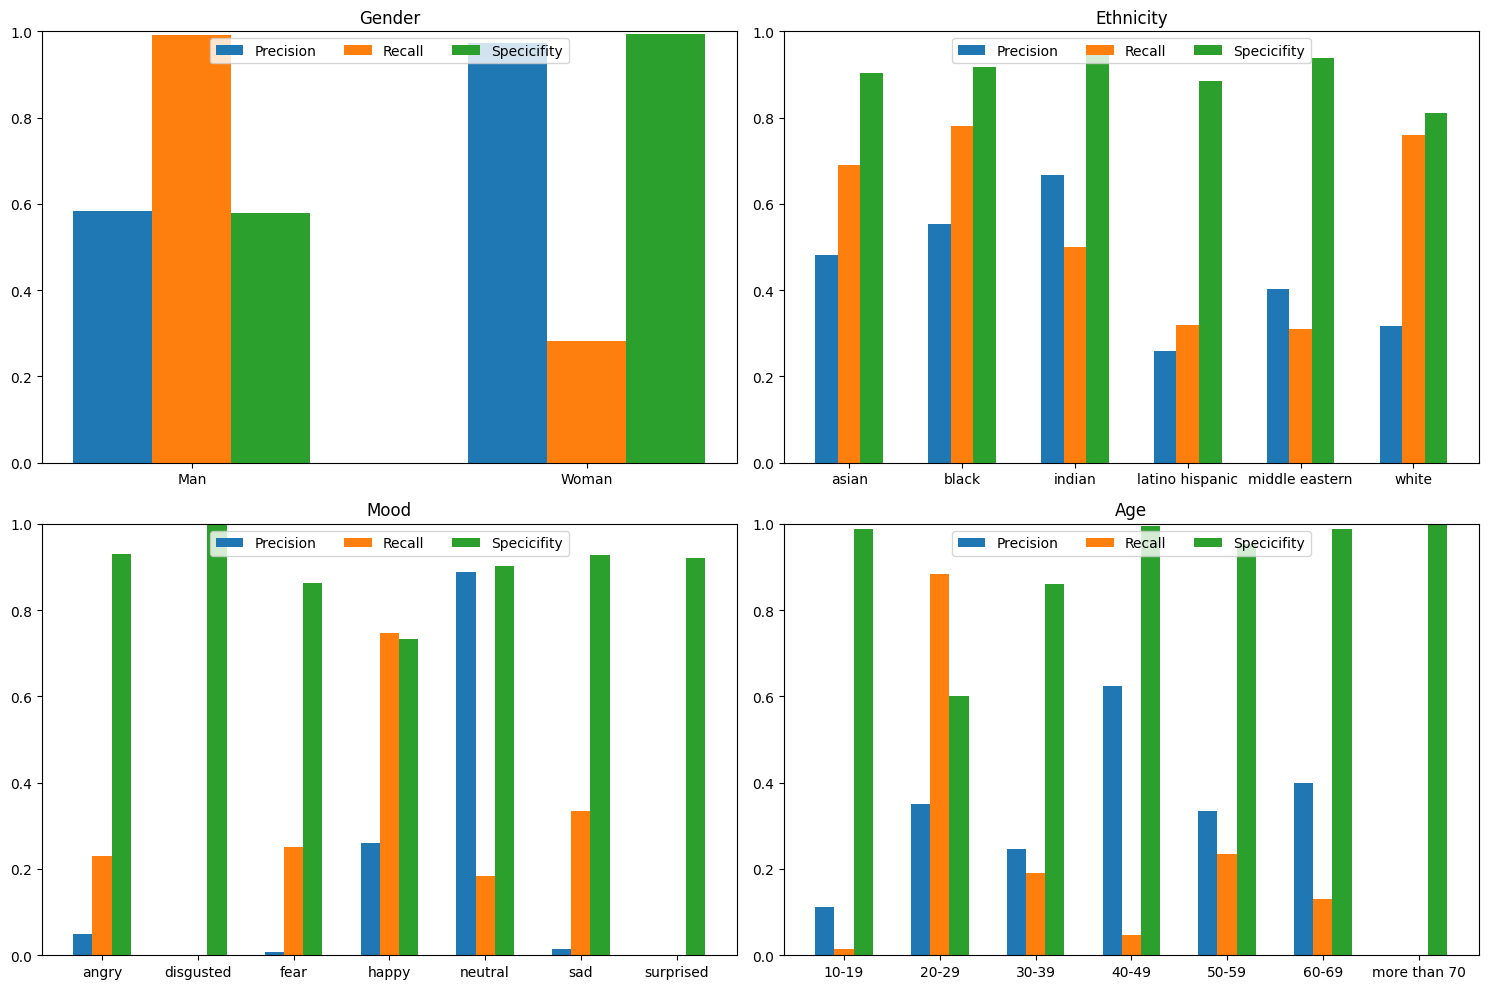

In [459]:
fig, axes = plt.subplots(2, 2, figsize = (15, 10))
width = 0.2
for i, (key, data) in enumerate(pr_results.items()):
    row, col = divmod(i, 2)
    multiplier = 0
    x = np.arange(len(data))

    for i in range(3):
        offset = width * multiplier
        axes[row, col].bar(x + offset, [t[i + 1] for t in data], width, label = ["Precision", "Recall", "Specicifity"][i])

        multiplier += 1
    
    axes[row, col].set_title(key)
    axes[row,col].set_xticks(x + width, [t[0] for t in data])
    axes[row, col].set_ylim(0, 1)
    axes[row, col].legend(loc = 'upper center', ncols = 3)

plt.tight_layout()

## Bias heatmaps

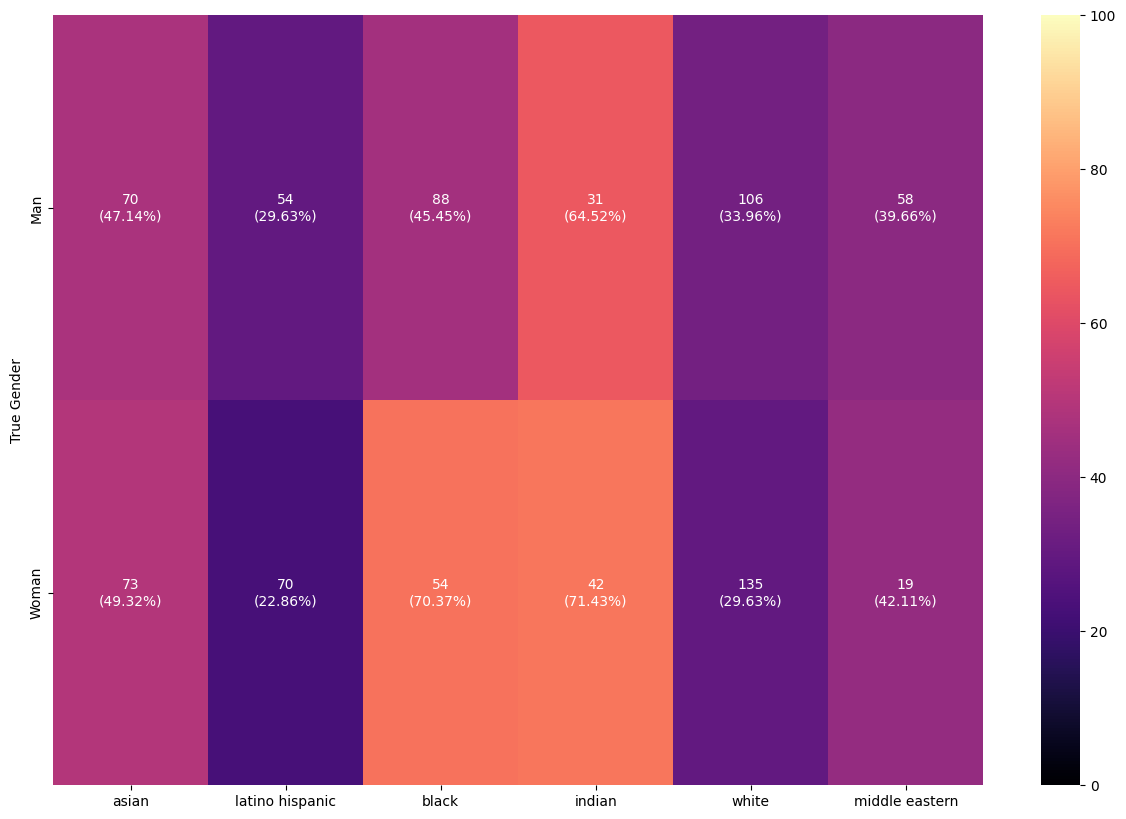

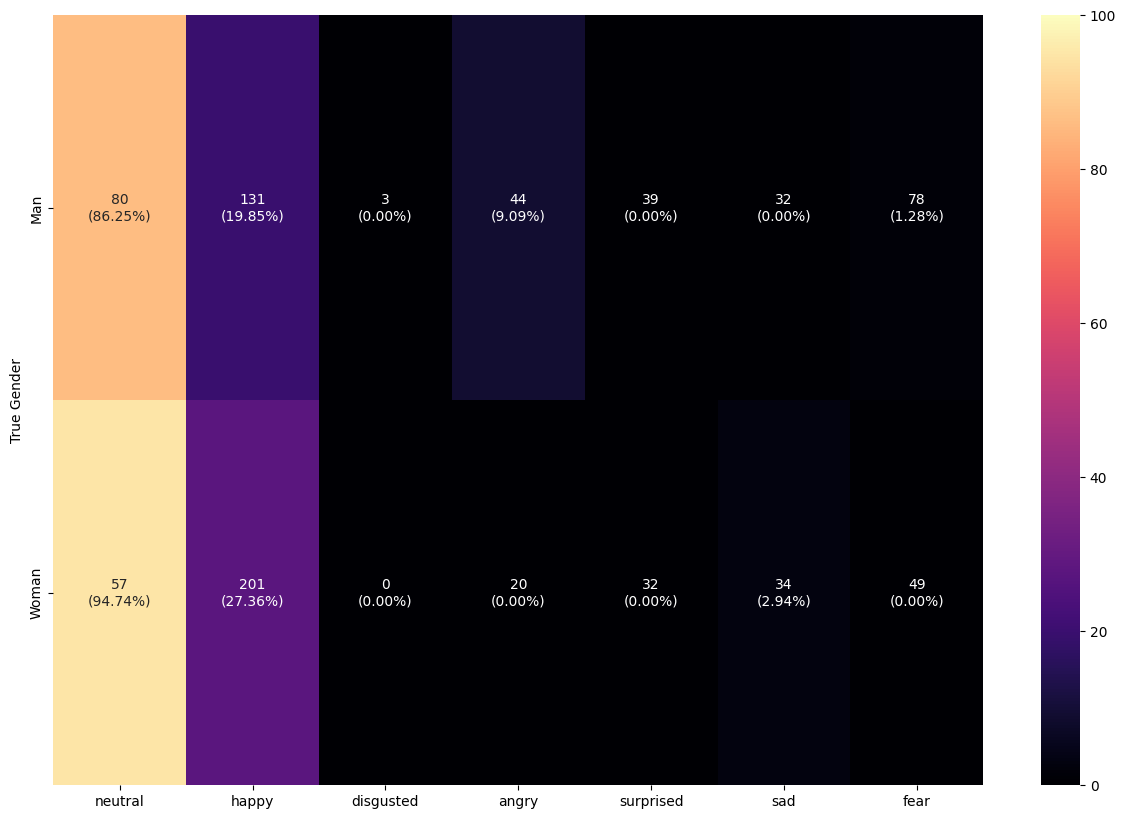

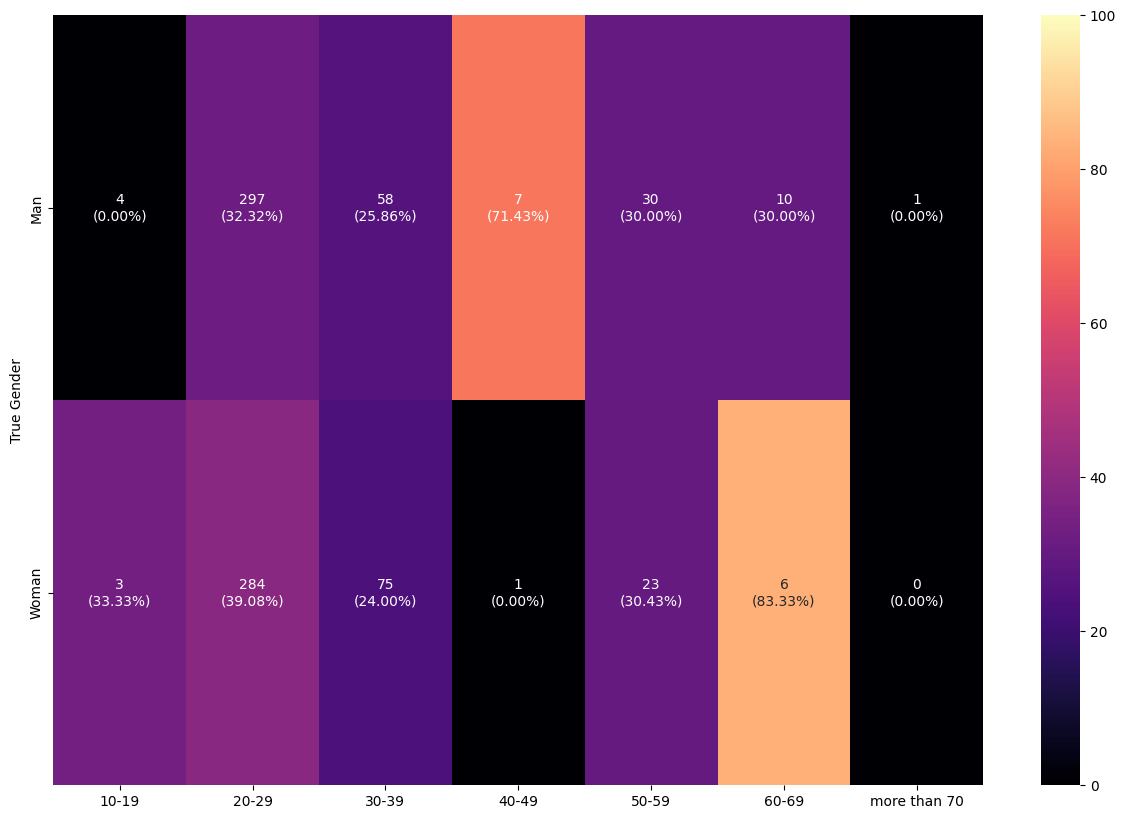

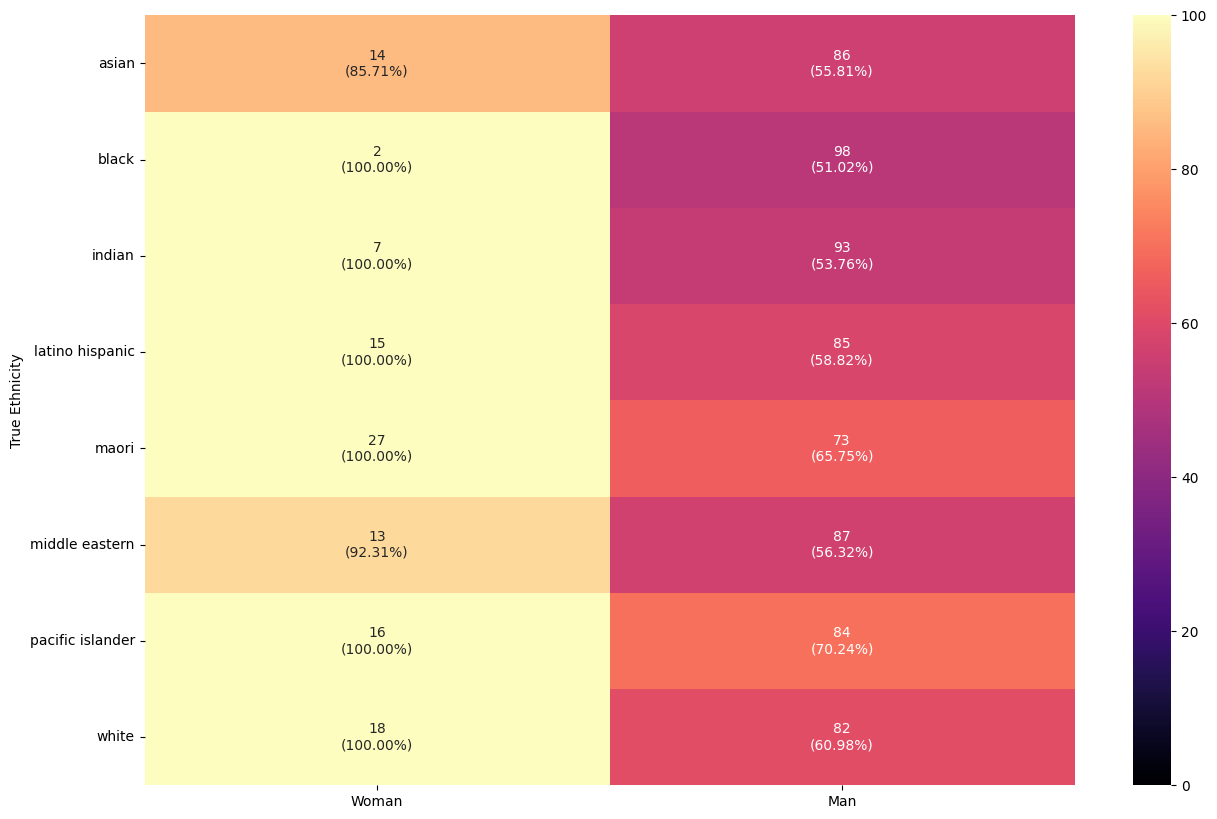

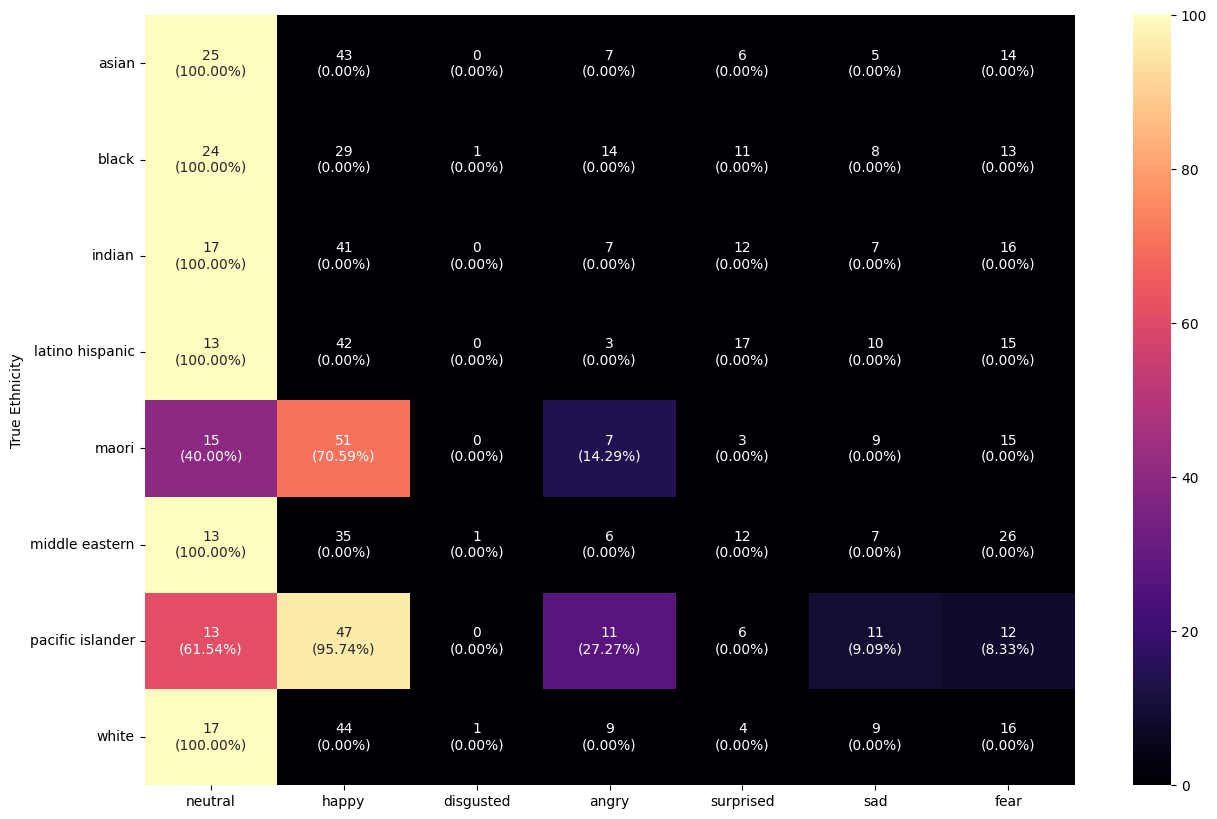

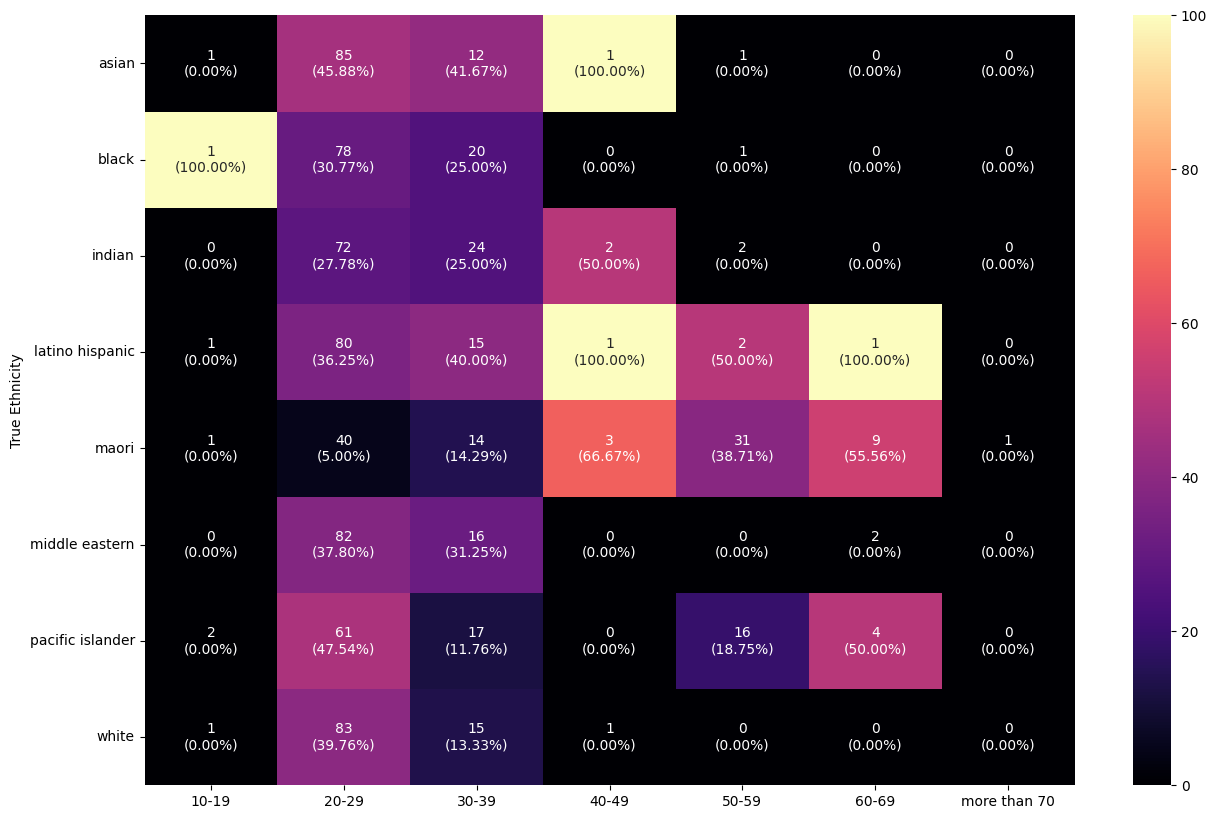

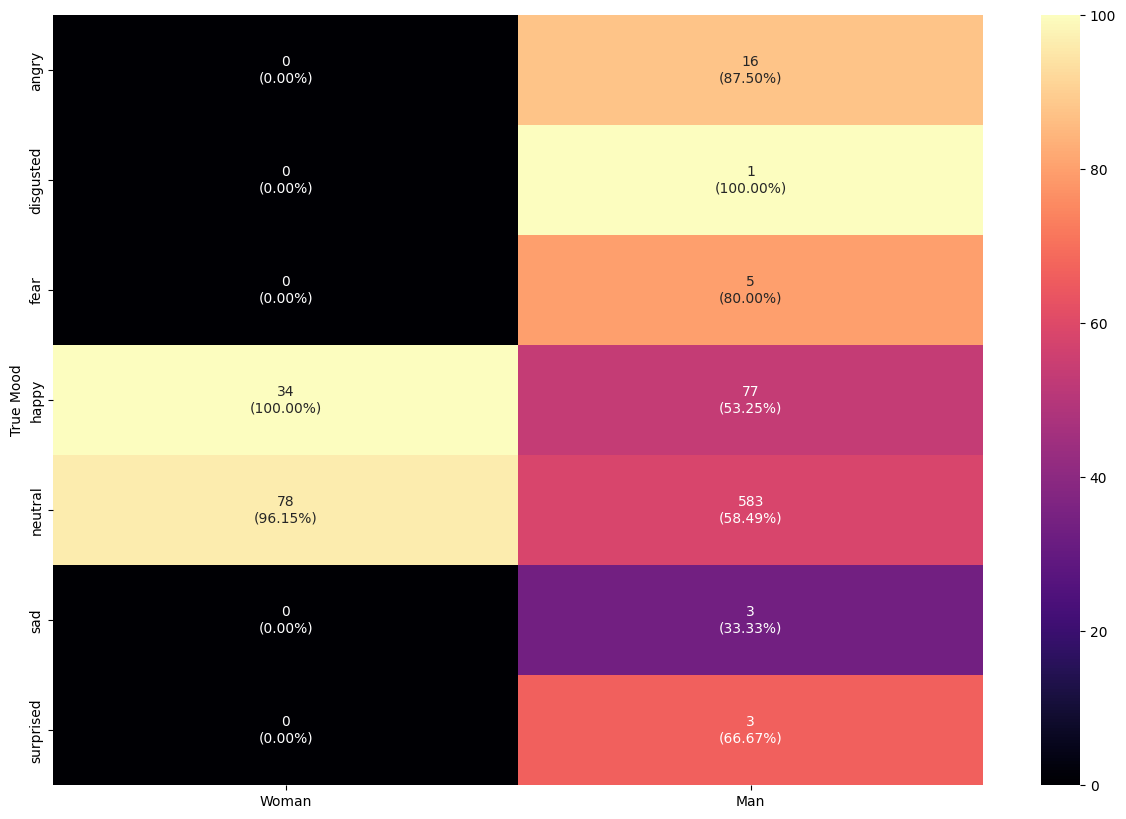

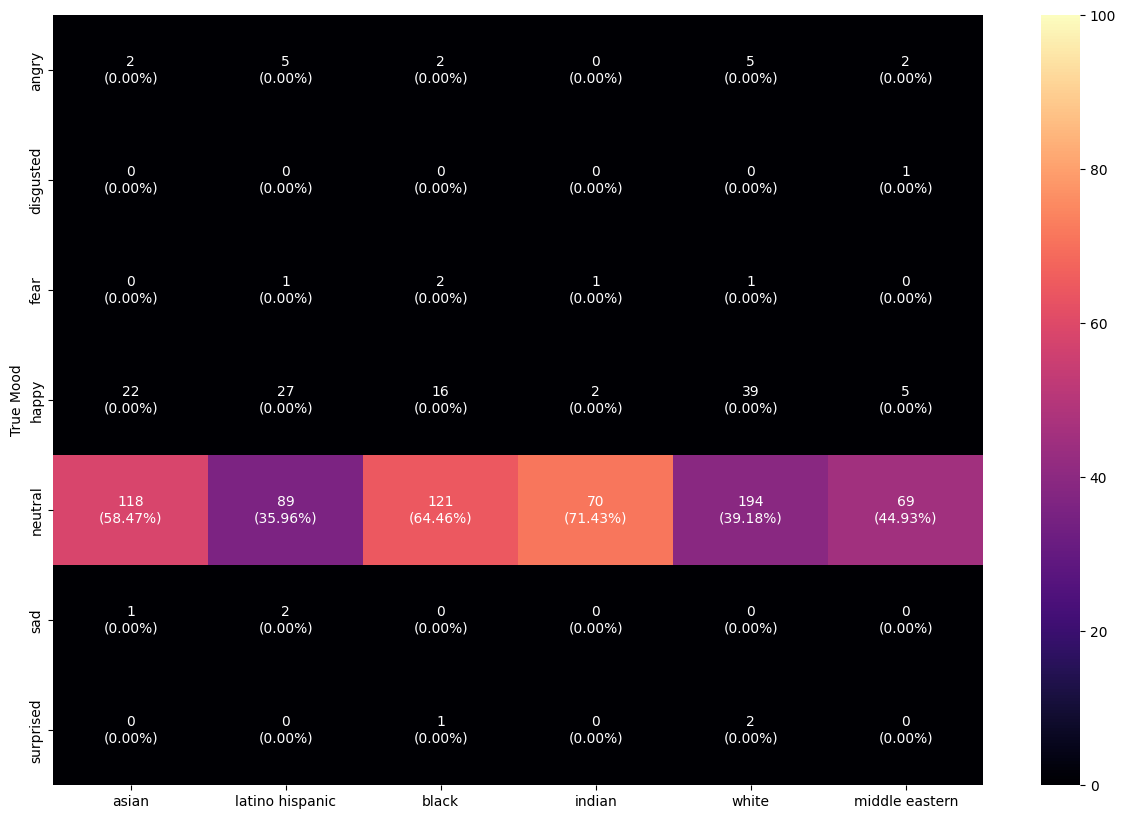

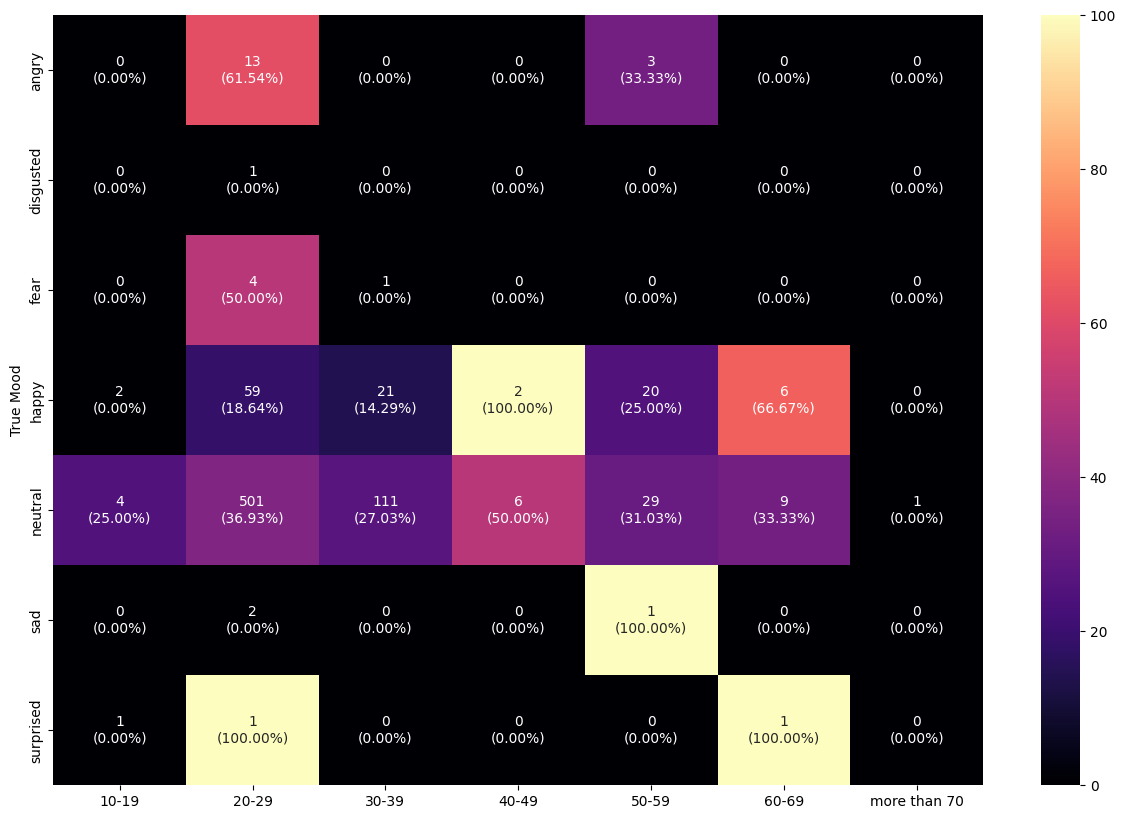

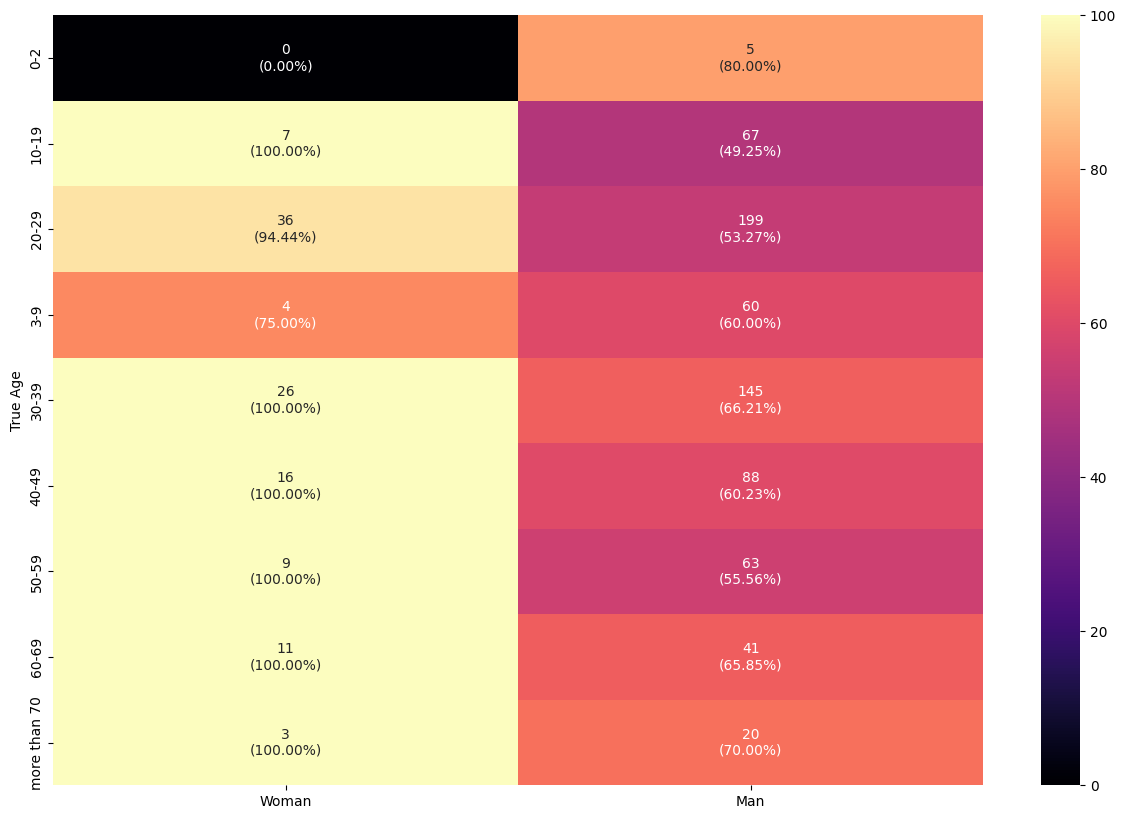

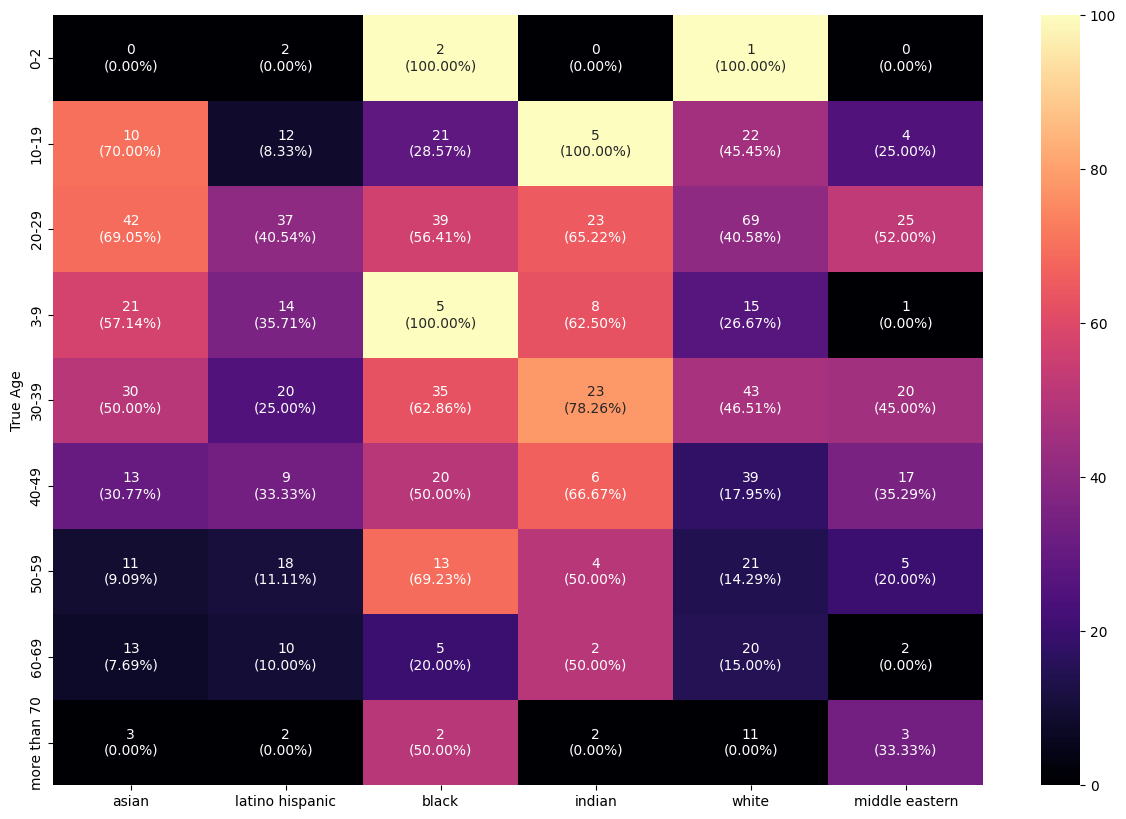

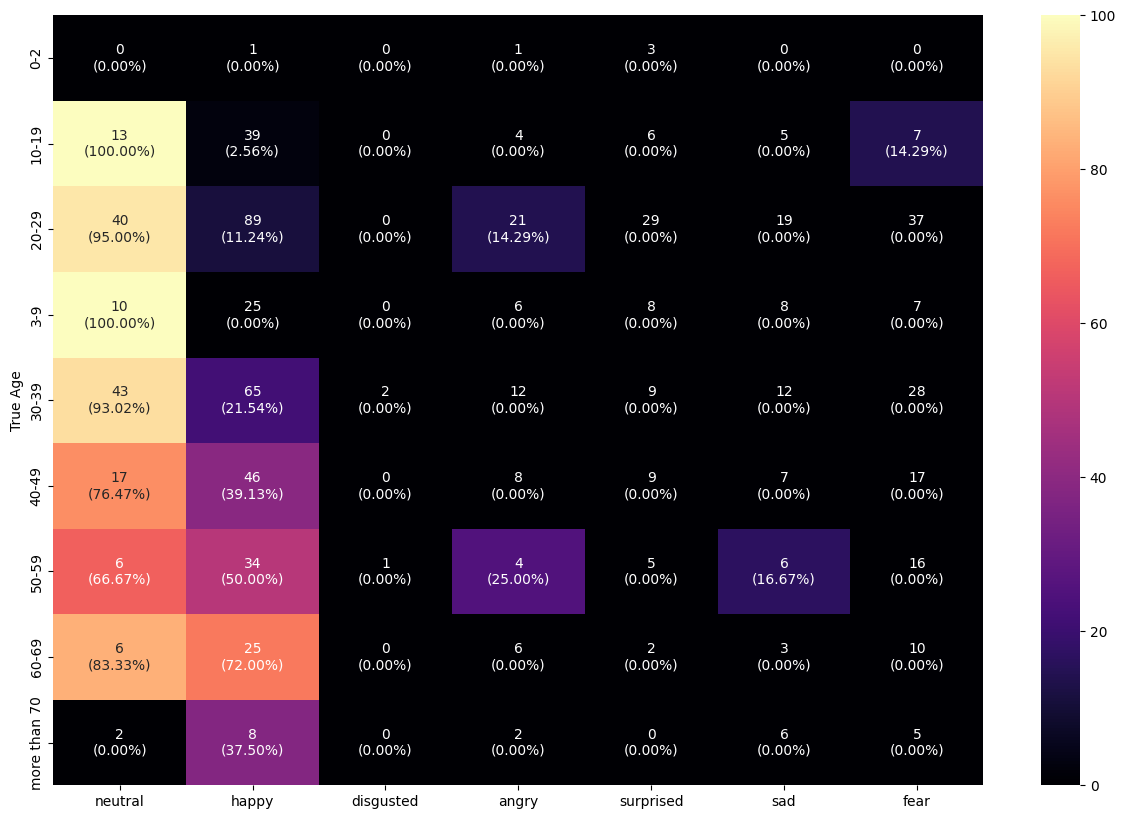

<Figure size 640x480 with 0 Axes>

In [460]:
count = 0
for (att1, inner) in c_matrices.items():
    for (att2, matrix) in inner.items():
        if att1 == att2:
            continue
        figure = plt.figure(figsize = (15, 10))
        annot_matrix = matrix.applymap(lambda t: str(t[1]) + f"\n({(100 * t[0]/t[1]) if t[1] != 0 else 0:.2f}%)")
        sn.heatmap(matrix.applymap(lambda t: (100 * t[0] / t[1]) if t[1] != 0 else 0),
                   vmin = 0,
                   vmax = 100,
                   cmap = "magma",
                   fmt = 's',
                   annot = annot_matrix)
        plt.show()

plt.tight_layout()

In [461]:
test = c_matrices["Mood"]["Ethnicity"]
display(test)

,asian,latino hispanic,black,indian,white,middle eastern
True Mood,,,,,,
angry,"(0, 2)","(0, 5)","(0, 2)","(0, 0)","(0, 5)","(0, 2)"
disgusted,"(0, 0)","(0, 0)","(0, 0)","(0, 0)","(0, 0)","(0, 1)"
fear,"(0, 0)","(0, 1)","(0, 2)","(0, 1)","(0, 1)","(0, 0)"
happy,"(0, 22)","(0, 27)","(0, 16)","(0, 2)","(0, 39)","(0, 5)"
neutral,"(69, 118)","(32, 89)","(78, 121)","(50, 70)","(76, 194)","(31, 69)"
sad,"(0, 1)","(0, 2)","(0, 0)","(0, 0)","(0, 0)","(0, 0)"
surprised,"(0, 0)","(0, 0)","(0, 1)","(0, 0)","(0, 2)","(0, 0)"
